# Image Segmentation
we discuss [UNETs](https://arxiv.org/abs/1505.04597) for image segmentation (on the NYUv2 dataset).

In [653]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import torch
import imageio
import argparse
import timeit
import numpy as np
import scipy.misc as misc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils import data
from torchsummary import summary

from nyuv2 import NYUv2Loader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here is what our training data looks like:

[ 0  3  4  5  7 10 12]


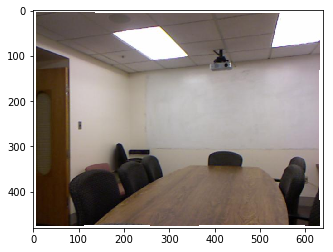

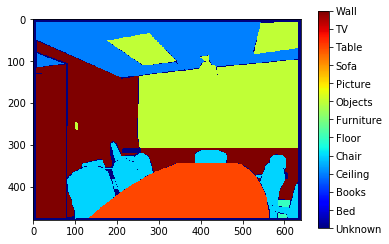

In [654]:
loader = NYUv2Loader(
    '/scratch_ssd/rkwitt/NYUv2/', 
    is_transform=True, 
    img_norm=True,
    img_size=(224, 320))
n_classes = loader.n_classes
cls = [v for k,v in loader.cls_idx_to_name.items()]

img_file = '../NYUv2/train/nyu_rgb_0019.png'
lab_file = '../NYUv2/train_annot/new_nyu_class13_0019.png'

plt.figure()
img = imageio.imread(img_file)
plt.imshow(img)

plt.figure()
lab = imageio.imread(lab_file).astype(int)
plt.imshow(lab, cmap=plt.cm.jet, alpha=1)
cbar = plt.colorbar(ticks=range(loader.n_classes));
cbar.ax.set_yticklabels(cls);
print(np.unique(lab))

In [655]:
def convert_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v
    return new_state_dict

In [658]:
from skimage.transform import resize
img = imageio.imread(img_file)
#resized_img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]))
resized_img = resize(
    img, 
    (loader.img_size[0], loader.img_size[1]),
    preserve_range=True,mode='reflect')
img = resized_img

In [659]:
img = img[:, :, ::-1]
img = img.astype(np.float64)
img -= loader.mean
img = img.astype(float) / 255.0
img = img.transpose(2, 0, 1)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).float()

In [660]:
unet_model_file = '/tmp/unet_epoch_85.pkl'

In [661]:
from unet import unet 
model = unet(num_classes = 14, is_deconv=True);
model.load_state_dict(convert_state_dict(torch.load(unet_model_file)));
model = model.to(device);
model.eval();

In [645]:
summary(model, input_size=(3, 224, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 320]           1,792
            Conv2d-2         [-1, 64, 224, 320]           1,792
              ReLU-3         [-1, 64, 224, 320]               0
              ReLU-4         [-1, 64, 224, 320]               0
              ReLU-5         [-1, 64, 224, 320]               0
              ReLU-6         [-1, 64, 224, 320]               0
              ReLU-7         [-1, 64, 224, 320]               0
              ReLU-8         [-1, 64, 224, 320]               0
            Conv2d-9         [-1, 64, 224, 320]          36,928
           Conv2d-10         [-1, 64, 224, 320]          36,928
             ReLU-11         [-1, 64, 224, 320]               0
             ReLU-12         [-1, 64, 224, 320]               0
             ReLU-13         [-1, 64, 224, 320]               0
             ReLU-14         [-1, 64, 2

In [662]:
img = img.to(device)
out = model(img)

In [663]:
pred = np.squeeze(out.data.max(1)[1].cpu().numpy(), axis=0)

In [664]:
decoded = loader.decode_segmap(pred)
print(np.unique(pred))

[ 0  1  3  4  5  6  7  9 10 12]


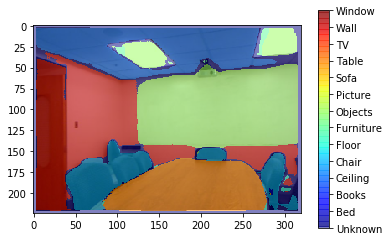

In [668]:
plt.figure()
plt.imshow(resized_img/255.0)
plt.imshow(pred,cmap=plt.cm.jet, alpha=0.5)
cbar = plt.colorbar(ticks=range(loader.n_classes));
plt.clim(0,13)
cbar.ax.set_yticklabels(cls);

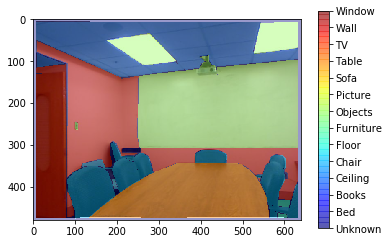

In [650]:
lab = imageio.imread(lab_file)
lab = lab.astype(int)
plt.figure()
plt.imshow(imageio.imread(img_file))
plt.imshow(lab, cmap=plt.cm.jet, alpha=0.4)
cbar = plt.colorbar(ticks=range(loader.n_classes));
plt.clim(0,13)
cbar.ax.set_yticklabels(cls);

float32
(14, 71680)
[ 0  1  3  4  5  6  7 10 12]


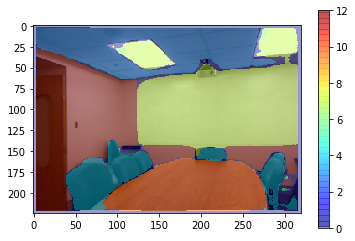

In [669]:
import pydensecrf.densecrf as dcrf

unary = out.data.cpu().numpy()
print(unary.dtype)
unary = np.squeeze(unary, 0)
unary = -unary.transpose(2, 1, 0)
w, h, c = unary.shape
unary = unary.transpose(2, 0, 1).reshape(loader.n_classes, -1)
print(unary.shape)
unary = np.ascontiguousarray(unary)

resized_img = np.ascontiguousarray(resized_img)

d = dcrf.DenseCRF2D(w, h, loader.n_classes)
d.setUnaryEnergy(unary)
d.addPairwiseBilateral(sxy=13, 
                       srgb=13, 
                       rgbim=resized_img.astype(np.uint8),
                       compat=1)

d.addPairwiseGaussian(sxy=13, 
                      compat=1, 
                      kernel=dcrf.DIAG_KERNEL, 
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

q = d.inference(10)
mask = np.argmax(q, axis=0).reshape(w, h).transpose(1,0)
plt.imshow(resized_img/255.0)
plt.imshow(mask, cmap=plt.cm.jet, alpha=0.4)
print(np.unique(mask))
plt.colorbar()